In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Variáveis para o gráfico

plot_params = {'legend.fontsize': 30,
               'figure.figsize': (20, 10),
               'axes.labelsize':  30,
               'axes.titlesize':  30,
               'xtick.labelsize': 25,
               'ytick.labelsize': 25}

plt.style.use('ggplot')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

color = [color_dark_blue, color_light_blue, purple]

# Modelo de volatilidade estocástica de Hull-White

O modelo de Hull-White supõe que, sob a medida neutra ao risco, $\mathbb{Q}$,
$$\left\{\begin{array}{lll} 
dS_t = r S_t dt + \sqrt{V_t} S_t dW^S_t,&\\ 
dV_t = \mu_V V_t dt + \sigma_V V_t dW^V_t,&
\end{array}\right. $$
onde $W^S$ e $W^V$ movimentos Brownianos independentes ($\rho=0$). O preço de qualquer derivativo com maturidade $T>0$ e com payoff $g(S_T)$ é dado por
\begin{align*}
P(0,x,v) &= \mathbb{E}_{\mathbb{Q}}[e^{-r(T-t)} g(S_T) \ | \ S_0=x, V_0=v] \\
&=\mathbb{E}_{\mathbb{Q}}[C^{BS}_0(S_0, T, g, r,  \sqrt{A_T})],
\end{align*}
onde $A_T = \frac{1}{T} \int_{0}^{T} V_t dt$ e $C^{BS}_t(S, T, g, r, \nu)$ é o preço do derivativo no tempo $t$ com payoff $g(S_T)$ no modelo de Black-Scholes com volatilidade $\nu$, taxa de juros $r$ e preço do ativo subjacente $S$ em $t$.

Para usarmos a fórmula acima para calcular $P(0,x,v)$ numericamente basta simularmos $M$ caminhos para o processo de variância $V_t$ numa discretização temporal $t_i$, $i=0,\ldots,N$, e aproximar então
$$P(0,x,v) \approx \frac{1}{M} \sum_{j=1}^M C^{BS}_0(S_0,  g, T, r,  \sqrt{A_T^{(j)}}),$$
onde
$$A_T^{(j)} \approx \frac{1}{N} \sum_{i=1}^N \sigma_{t_i}^2.$$

In [4]:
#algumas funções de simulação e do modelo de Black-Scholes
def SimulateBrownian(N, M, dt):
    dW = np.sqrt(dt) * np.random.normal(size=(N,M))
    brownian_paths = np.zeros((N+1,M))
    brownian_paths[1:,:] = np.cumsum(dW, axis=0)
    
    return brownian_paths

def SimulateGBM(S0, sigma, drift, N, M, time, W=None):

    dt = time[1] - time[0]
    time_matrix = np.repeat(time, M).reshape(N+1,M) # vetor de tempos repetidos
    
    if W is None:
        W = SimulateBrownian(N, M, dt)

    paths = S0 * np.exp((drift - sigma**2/2) * time_matrix + sigma * W)

    return paths

def BlackScholesFormula(S, T, K, sigma, r):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
    return call_price

def BlackScholesVega(S, T, K, sigma, r):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    
    call_vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return call_vega

def ImpliedVolatility(S, T, K, r, call_price, sigma0=0.2):
    
    func = lambda sigma: BlackScholesFormula(S, T, K, sigma, r) - call_price
    fprime = lambda sigma: BlackScholesVega(S, T, K, sigma, r)
    
    res = newton(func, x0=sigma0, fprime=fprime)
    
    return res

In [5]:
def HullWhitePricing(S0, T, K, r, params, time, M, W=None):
    '''
    Função que calcula o preço de uma call (T,K) no modelo de Hull-White
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    K (array > 0) - strikes
    r (float) - taxa de juros livre de risco
    param(dict) - dicionário com as seguintes keys: 'vol_V', 'drift_V' e 'V0':
        vol_V (float > 0) - vol-vol
        V0 (float > 0) - vol inicial
        drift_V (float) - drift da vol
    N (int) - discretização do tempo
    M (int) - número de simulações para estimação por Monte Carlo
    '''

    vol_V = params['vol_V']
    drift_V = params['drift_V']
    V0 = params['V0']
    
    dt = time[1] - time[0]

    V = SimulateGBM(V0, vol_V, drift_V, N, M, time, W)

    avarage_vol = np.sqrt(1/T * np.sum(V, axis=0) *  dt)

    call_prices = np.zeros(len(K))
    ci = np.zeros(len(K))

    for i in range(len(K)):
        call_sim = BlackScholesFormula(S0, T, K[i], avarage_vol, r)

        call_prices[i] = np.mean(call_sim)
        ci[i] = 1.96 * np.std(call_sim, ddof=1)/np.sqrt(M) #intervalo de confiança

    return call_prices, ci

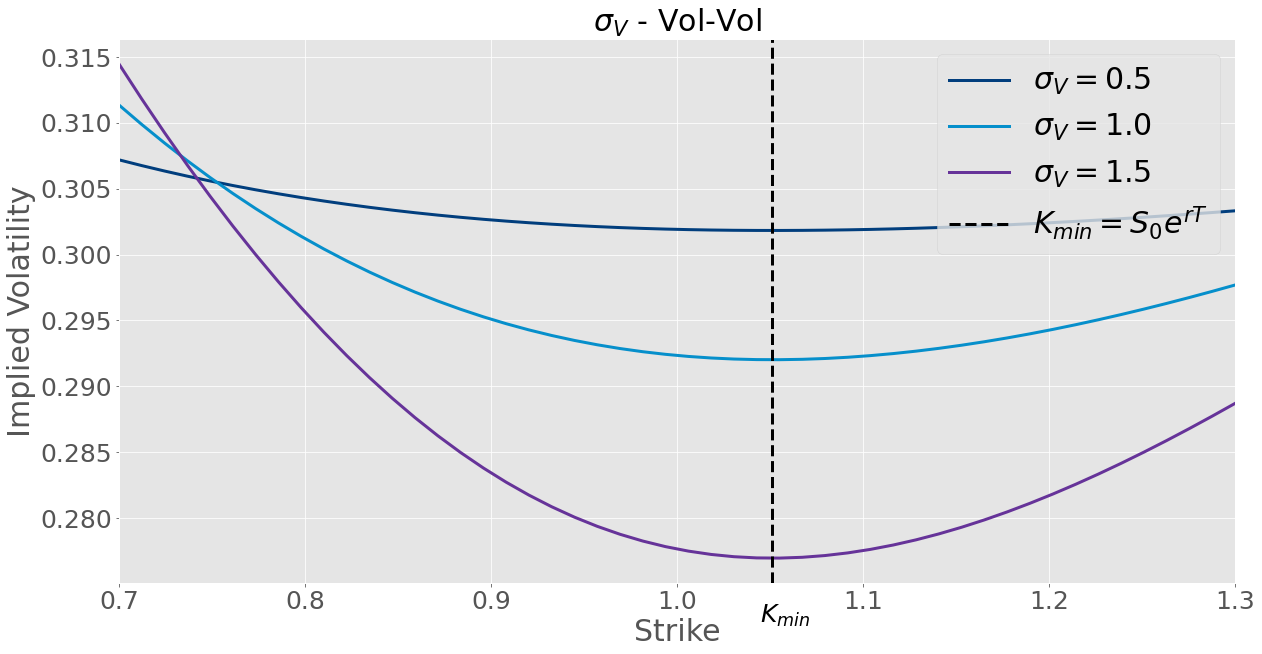

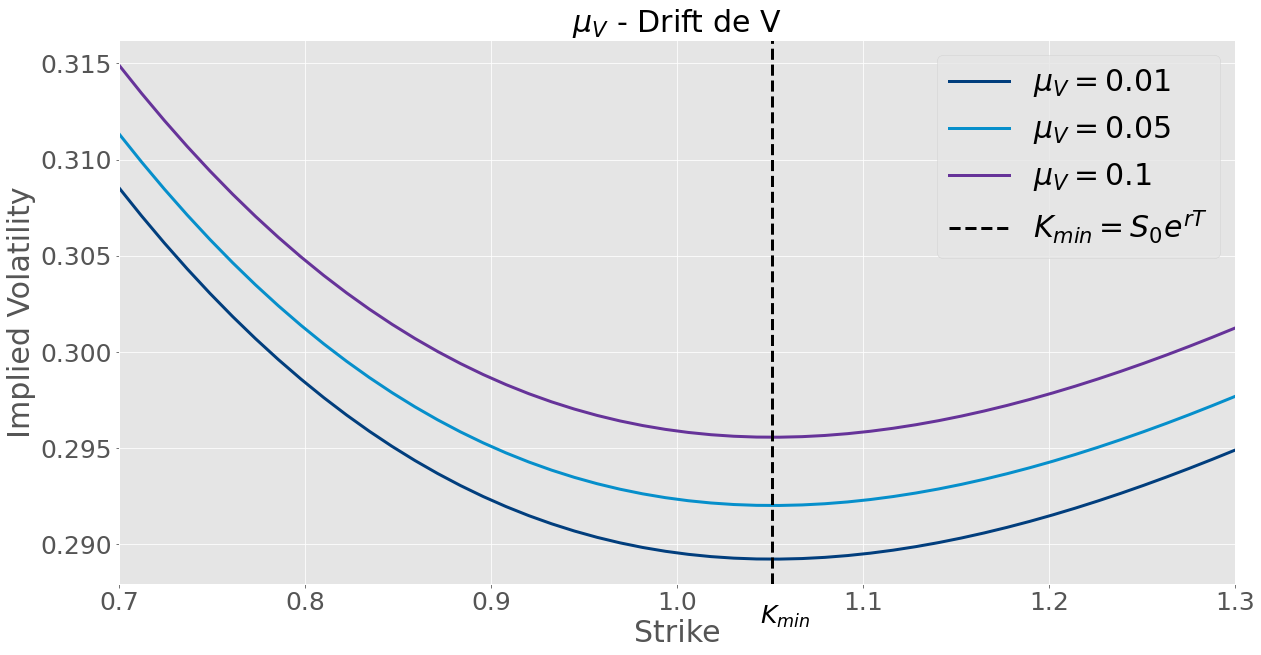

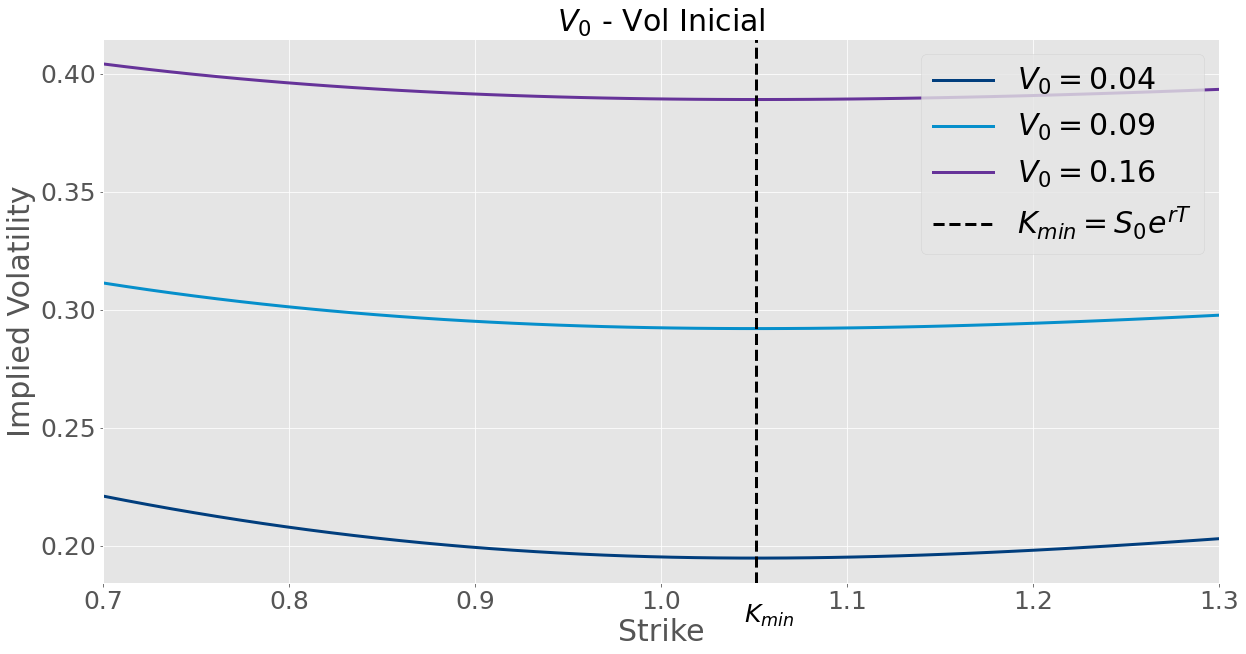

In [6]:
T = 1 #maturidade
S0 = 1 #valor inicial do ativo subjacente
K = S0 * np.linspace(0.7, 1.3, 50) #strikes
r = 0.05 # taxa de juros livre de risco
params =  {'vol_V': 1.0, 'drift_V':0.05, 'V0': 0.09} #baseline dos parâmetros

N = 100 # discretização do tempo
M = 10000 # número de simulações
time = np.linspace(0, T, N+1) # time vector
dt = time[1] - time[0]

W = SimulateBrownian(N, M, dt)

plt.rcParams.update(plot_params)

param_vary = {'vol_V': [0.5,1.0, 1.5], 'drift_V':[0.01, 0.05, 0.1], 
              'V0': [0.04, 0.09, 0.16]} #variação dos parâmetros

tex_param = {'vol_V': '\\sigma_V', 'drift_V':'\\mu_V', 
             'V0': 'V_0'} #latex do parâmetros para plot
text_param = {'vol_V': 'Vol-Vol', 'drift_V':'Drift de V', 
              'V0': 'Vol Inicial'} #nome do parâmetros para plot

for param in ['vol_V', 'drift_V', 'V0']:

    implied_vol_vary = []

    for p in param_vary[param]:

        params[param] = p

        call_prices, _ = HullWhitePricing(S0, T, K, r, params, time, M, W)
        
        implied_vols = np.zeros(len(K))

        for i in range(len(K)):
            implied_vols[i] = ImpliedVolatility(S0, T, K[i], r, call_prices[i])

        implied_vol_vary.append(implied_vols)

    params[param] = param_vary[param][1] #volta com o valor baseline
    
    plt.figure()    
    for i in [0,1,2]:
        plt.plot(K, implied_vol_vary[i], linewidth=3 ,label=r'$' + tex_param[param]  + ' = ' + str(param_vary[param][i]) + '$', color=color[i])
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.xlim(K[0], K[-1])
    plt.axvline(S0 * np.exp(r*T), color='k', linestyle='dashed', linewidth=3, label=r'$K_{min} = S_0 e^{rT}$')
    plt.gcf().text(0.57, 0.07, r'$K_{min}$', fontsize=25)
    plt.legend(loc='upper right')
    plt.title(r'$' + tex_param[param] + '$ - ' + text_param[param])